In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from betareg import Beta  #Taken from https://gist.github.com/brentp/089c7d6d69d78d26437f
import statsmodels.api as sm

In [3]:
df8=pd.read_pickle("Data/df8.pickle")
df8.columns = df8.columns.str.strip()\
                         .str.lower()\
                         .str.replace('+','plus')\
                         .str.replace('^','')\
                         .str.replace(' ', '_')\
                         .str.replace('[', '')\
                         .str.replace(']', '')\
                         .str.replace('/', '')\
                         .str.replace('_mgl','')

df8.columns = df8.columns.str.replace('salinity_gl','s')\
                         .str.replace('temperature','t')

In [4]:
outMetals=df8.columns[df8.columns.str.contains('outin')]
outMetals=outMetals[~outMetals.str.contains('|'.join(['al','li']))]

In [5]:
eps=1e-2
for metal in outMetals:
    df8[metal+'_logit']=np.where(df8[metal]==0.0,
                                 np.log((df8[metal]+eps)/(1.0-df8[metal]-eps)),
                                 np.log(df8[metal]/(1.0-df8[metal]))
                                 )

C:\Users\gth\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
C:\Users\gth\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [6]:
#Features selected for the regression model
X=df8[['mg','ca','ph','s']]
X=sm.add_constant(X)
est={}
eps=1e-3
for metal in outMetals:
    if ~df8[metal].isnull().values.any():
        estM=Beta(np.where(df8[metal]==0.0,df8[metal]+eps,df8[metal]),X,missing = 'drop')
        est[metal] = estM.fit()
    else:
        est[metal]=sm.OLS(df8[metal+'_logit'],X,missing = 'drop').fit()

C:\Users\gth\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\gth\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:159: RuntimeWarning: invalid value encountered in double_scalars
  f(*((x-ei,)+args), **kwargs))/(2 * epsilon[k])
C:\Users\gth\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gth\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gth\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:159: RuntimeWarni

In [12]:
est['sr_outin_ratio'].params

array([-0.07182302,  0.67173096, -0.21992927,  0.85884272,  0.00825967,
        1.24155973])

In [7]:
import string
Alphabet=string.ascii_uppercase[:len(X.columns)]
############################################################################################
for metal in outMetals:
    if est[metal].bse[0]!=np.inf:
        print("def "+metal[:2]+"Out0(P):")
        out="    out="
        for (i,y) in enumerate(X.columns):
            print("    "+Alphabet[i]+"="+str(est[metal].params[i])+"    #"+y)
            if i==0:
                out=out+Alphabet[i]+"+"   
            else:   
                out=out+Alphabet[i]+"*P['"+y+"']+"
        print(out[:-1])
        print("    return 1.0/(1.0+np.exp(-out))")
     #########################################################################
        print("def "+metal[:2]+"Out(P):")
        for (i,y) in enumerate(X.columns):
            print("    "+Alphabet[i]+"="+str(est[metal].params[i])+"    #"+y)

        print(out[:-1])
        print("    out=1.0/(1.0+np.exp(-out))")
        print("    phi=np.exp("+str(est[metal].params[-1])+")")
        print("    p=out*phi")
        print("    q=(1-out)*phi")
        print("    return np.random.beta(p,q)")
    #########################################################################
    else:
        print("def "+metal[:2]+"Out0(P):")
        out="    out="
        for (x,y) in zip(string.ascii_uppercase[:len(X.columns)],X.columns):
            print("    "+x+"="+str(est[metal].params[y])+"    #"+y)
            if y=='const':
                out=out+x+"+"   
            else:   
                out=out+x+"*P['"+y+"']+"
        print(out[:-1])
        print("    return 1.0/(1.0+np.exp(-out))")
        
        print("def "+metal[:2]+"Out(P):")
        out="    out="
        for (x,y) in zip(string.ascii_uppercase[:len(X.columns)],X.columns):
            print("    "+x+"="+str(est[metal].params[y])+"    #"+y)
            if y=='const':
                out=out+x+"+"   
            else:   
                out=out+x+"*P['"+y+"']+"
        print(out[:-1])
        print("    return 1.0/(1.0+np.exp(-out))")
    print("")

C:\Users\gth\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


def srOut0(P):
    A=-0.07182302079612728    #const
    B=0.6717309613913651    #mg
    C=-0.2199292734310563    #ca
    D=0.858842716902609    #ph
    E=0.008259668375545511    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def srOut(P):
    A=-0.07182302079612728    #const
    B=0.6717309613913651    #mg
    C=-0.2199292734310563    #ca
    D=0.858842716902609    #ph
    E=0.008259668375545511    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    out=1.0/(1.0+np.exp(-out))
    phi=np.exp(1.2415597254803088)
    p=out*phi
    q=(1-out)*phi
    return np.random.beta(p,q)

def mnOut0(P):
    A=-5.7676419520922356e-05    #const
    B=-0.00493710150821031    #mg
    C=-0.017475955104993997    #ca
    D=0.6909779797606459    #ph
    E=-8.939845020709673e-05    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def mnOut(P):
    A=-5.7676419520922356e-05    #const
    B=-0.00493710150821031    #mg
    C=-0.017475

In [8]:
def srOut0(P):
    A=-0.07182302079612728    #const
    B=0.6717309613913651    #mg
    C=-0.2199292734310563    #ca
    D=0.858842716902609    #ph
    E=0.008259668375545511    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def srOut(P):
    A=-0.07182302079612728    #const
    B=0.6717309613913651    #mg
    C=-0.2199292734310563    #ca
    D=0.858842716902609    #ph
    E=0.008259668375545511    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    out=1.0/(1.0+np.exp(-out))
    phi=np.exp(1.2415597254803088)
    p=out*phi
    q=(1-out)*phi
    return np.random.beta(p,q)

def mnOut0(P):
    A=-5.7676419520922356e-05    #const
    B=-0.00493710150821031    #mg
    C=-0.017475955104993997    #ca
    D=0.6909779797606459    #ph
    E=-8.939845020709673e-05    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def mnOut(P):
    A=-5.7676419520922356e-05    #const
    B=-0.00493710150821031    #mg
    C=-0.017475955104993997    #ca
    D=0.6909779797606459    #ph
    E=-8.939845020709673e-05    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))

def baOut0(P):
    A=-0.037165366851088545    #const
    B=0.3475789765850369    #mg
    C=-0.11384595619348536    #ca
    D=0.48254849811399897    #ph
    E=0.0042737944187502905    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def baOut(P):
    A=-0.037165366851088545    #const
    B=0.3475789765850369    #mg
    C=-0.11384595619348536    #ca
    D=0.48254849811399897    #ph
    E=0.0042737944187502905    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    out=1.0/(1.0+np.exp(-out))
    phi=np.exp(1.2779284963231563)
    p=out*phi
    q=(1-out)*phi
    return np.random.beta(p,q)

def asOut0(P):
    A=-0.030445866445660354    #const
    B=0.2863491149558746    #mg
    C=-0.0881696244796751    #ca
    D=0.17286690059868276    #ph
    E=0.0035293654027853238    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def asOut(P):
    A=-0.030445866445660354    #const
    B=0.2863491149558746    #mg
    C=-0.0881696244796751    #ca
    D=0.17286690059868276    #ph
    E=0.0035293654027853238    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    out=1.0/(1.0+np.exp(-out))
    phi=np.exp(1.291946229971806)
    p=out*phi
    q=(1-out)*phi
    return np.random.beta(p,q)

def znOut0(P):
    A=-0.0036593181003814336    #const
    B=0.03194429336654166    #mg
    C=-0.0184077577348168    #ca
    D=0.22431752394914742    #ph
    E=0.00038085190340075614    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def znOut(P):
    A=-0.0036593181003814336    #const
    B=0.03194429336654166    #mg
    C=-0.0184077577348168    #ca
    D=0.22431752394914742    #ph
    E=0.00038085190340075614    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    out=1.0/(1.0+np.exp(-out))
    phi=np.exp(1.2746998786295562)
    p=out*phi
    q=(1-out)*phi
    return np.random.beta(p,q)

def rbOut0(P):
    A=-0.005204497354612378    #const
    B=-0.029977904762520758    #mg
    C=-0.26438846561389867    #ca
    D=1.001534281447631    #ph
    E=-0.0007806746031906527    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def rbOut(P):
    A=-0.005204497354612378    #const
    B=-0.029977904762520758    #mg
    C=-0.26438846561389867    #ca
    D=1.001534281447631    #ph
    E=-0.0007806746031906527    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))

def niOut0(P):
    A=-0.0044332994223507585    #const
    B=-0.025535804672687117    #mg
    C=-0.2252116106549492    #ca
    D=1.159236910484545    #ph
    E=-0.0006649949133512361    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))
def niOut(P):
    A=-0.0044332994223507585    #const
    B=-0.025535804672687117    #mg
    C=-0.2252116106549492    #ca
    D=1.159236910484545    #ph
    E=-0.0006649949133512361    #s
    out=A+B*P['mg']+C*P['ca']+D*P['ph']+E*P['s']
    return 1.0/(1.0+np.exp(-out))

In [9]:
for metal in outMetals:
    m=metal[:2]
    fun0=globals()[m+'Out0']
    df8[metal+'_model']=df8.apply(lambda row: fun0(row), axis=1)
    try:
        fun=globals()[m+'Out']
        df8[[m+'2p3',m+'15p9',m+'84p1',m+'97p7']]=df8.apply(lambda row: pd.Series(np.round(np.percentile([fun(row) for i in range(1000)],[2.3,15.9,84.1,97.7]),1)),axis=1)
    except KeyError:
        df8[[m+'2p3',m+'15p9',m+'84p1',m+'97p7']]=df8.apply(lambda row: np.nan,axis=1)
                
    df8[metal+'_model_error']=df8[m+'_outin_ratio_model']-df8[m+'_outin_ratio']

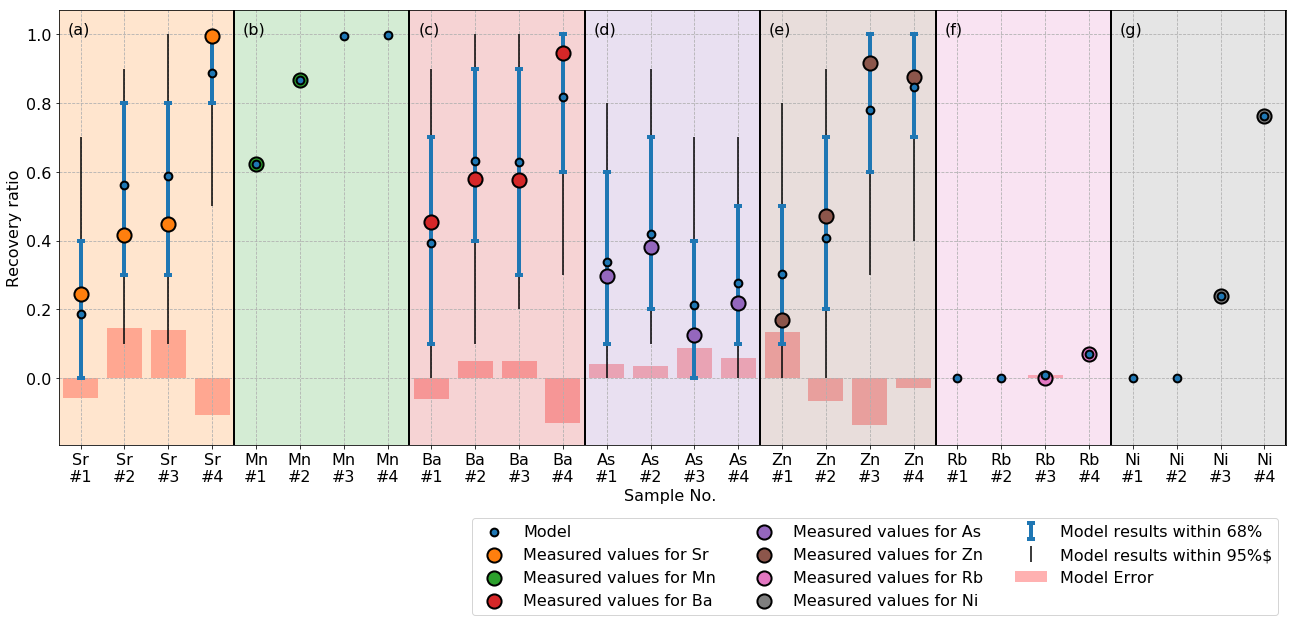

In [10]:
plt.rcParams.update({'font.size': 16})
fig,ax=plt.subplots(figsize=(22,8))
i=1
label_list=['(a)','(b)','(c)','(d)','(e)','(f)','(g)']
metalnames=[]
for (n,metal) in enumerate(outMetals):
    m    =metal[:2]
    data =df8[metal]
    error=df8[metal+'_model_error']
    m2p3 =df8[m+'2p3']
    m15p9=df8[m+'15p9']
    m84p1=df8[m+'84p1']
    m97p7=df8[m+'97p7']
    
    model=df8[metal+'_model']
    
    N=len(model)


    if ~data.isna().any():
        ax.errorbar(range(i,i+4),
                    model.values,
                    yerr=np.vstack([model.values-m15p9.values,
                                    m84p1.values-model.values]),
                    capsize=4,
                    capthick=4,
                    linewidth=4,
                    color='C0',
                    fmt ='none',
                    zorder=10,
                    label='Model results within 68%' if n==0 else '')

        ax.errorbar(range(i,i+4),
                    model.values,
                    yerr=np.vstack([model.values-m2p3.values,
                                    m97p7.values-model.values]),
                    capsize=0,
                    capthick=2,
                    color='black',
                    fmt ='none',
                    zorder=5,
                    label='Model results within 95%$' if n==0 else '')
        ax.axvspan(i-0.5, i+3.5, facecolor='C'+str(n+1), alpha=0.2)
    else:
        ax.axvspan(i-0.5, i+3.5, facecolor='C'+str(n+1), alpha=0.2)
     

    ax.scatter(range(i,i+4),model,color='C0',s=60,edgecolor='k',lw=2,zorder=25,label='Model' if n==0 else '')          
    ax.scatter(range(i,i+4),data,color='C'+str(n+1),s=200,edgecolor='k',lw=2,zorder=20,label='Measured values for ' +metal[0:2].capitalize())   
    ax.bar(range(i,i+4),error,color='red',alpha=0.3,zorder=0,label='Model Error' if n==0 else '')
    ax.axvline(i+3.5,color='black',linewidth=2)

    metalnames+=[m.capitalize()+'\n#'+str(i) for i in range(1,5)]
    ax.grid()
    m=metal[:2]
    i+=4
    ax.text(i-4-0.3,1.0,"{}".format(label_list[int(i/4)-1]))
ax.set_xticks(range(1,i));
ax.set_xlim(0.5,4*len(outMetals)+0.5)
ax.set_xticklabels(metalnames);
ax.set_ylabel("Recovery ratio")
ax.set_xlabel("Sample No. ")
ax.grid(linestyle='dashed')
ax.legend(ncol=3,bbox_to_anchor=(1, -0.15))
plt.savefig("GDEx_Romanian_Model.png", bbox_inches='tight')

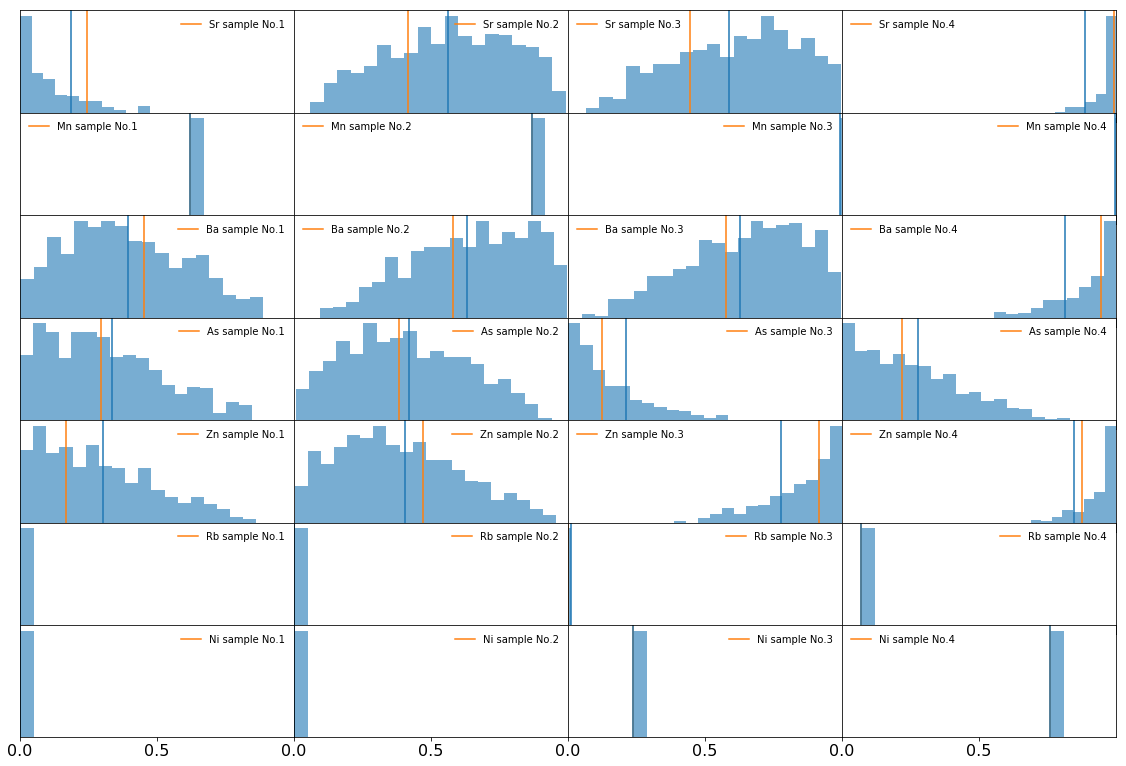

In [10]:
fig,ax=plt.subplots(7,4,figsize=(15,10),sharex=True)
n=0
for metal in outMetals:
    m=metal[:2]
    fun=globals()[m+'Out']
    for index, row in df8.iterrows():
        try: 
            ax[n//4][n%4].hist([fun(row) for i in range(1000)],20,label=None,alpha=0.6)
            ax[n//4][n%4].axvline(df8[metal].iloc[index],color='C1',label=m.capitalize()+' sample No.'+str(index+1));
            ax[n//4][n%4].axvline(df8[metal+'_model'].iloc[index],color='C0',label=None);
            ax[n//4][n%4].legend(fontsize=10,frameon=False)
        except NameError:
            ax[n//4][n%4].axvline(df8[metal].iloc[index],color='C1',label=m.capitalize()+' sample No.'+str(index+1));
            ax[n//4][n%4].axvline(df8[metal+'_model'].iloc[index],color='C0',label=None);
            ax[n//4][n%4].legend(fontsize=10,frameon=False)
        n+=1
    
for n in range(4*7):
    ax[n//4][n%4].set_yticks([])
    ax[n//4][n%4].set_xlim(0,1)
    ax[n//4][n%4].set_xticks([0,0.5])

plt.tight_layout(pad=-1)
plt.savefig("GEDx_Romanian_Model_histograms.png", bbox_inches='tight')